In [1]:
!pip install -q opencv-python matplotlib


You should consider upgrading via the '/Users/filipporeucci/oilSpotRecognition/myvenv/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os, cv2, csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cv2 import GaussianBlur
from skimage import metrics
from skimage.metrics import structural_similarity as ssim
#from image_hclustering import clusterMatrixMain

In [3]:
def plot_histogram(image_path):    
    ddepth = cv2.CV_16S
    kernel_size = 3
    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # Load an image

    image = cv2.GaussianBlur(image, (201,201), 0) # Apply Gaussian Blur - reduce noise
    
    dst = cv2.Laplacian(image, ddepth, ksize=kernel_size) # Apply Laplace function
    
    abs_dst = cv2.convertScaleAbs(dst) # Converting back to uint8
    
    hist_gray = cv2.calcHist([abs_dst], [0], None, [256], [0, 256]) # Calculate histogram
    return hist_gray

In [4]:
def process_image(image_path):
    ddepth = cv2.CV_16S
    kernel_size = 3
    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale

    image = cv2.resize(image, (256,256))

    #image = cv2.equalizeHist(image)

    '''clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) # regulate brightness
    image = clahe.apply(image)'''
    
    image = cv2.GaussianBlur(image, (7,7), 0) # Apply Gaussian Blur - reduce noise
    #image = cv2.medianBlur(image,5) # Apply Median Blur
    
    #image = cv2.Laplacian(image, ddepth, ksize=kernel_size) # Apply Laplace function

    #image = cv2.convertScaleAbs(image) # Converting back to uint8

    #threshold = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    #threshold2 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    #threshold3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
    
    # Dilation
    #kernel = np.ones((5,5), np.uint8)
    #dilate_image = cv2.dilate(threshold2, kernel, iterations=2)

    return image

In [5]:
def plot_histogram_processing_img(image_path):    
    image_processed = process_image(image_path)
    
    hist_gray = cv2.calcHist([image_processed], [0], None, [256], [0, 256]) # Calculate histogram
    return hist_gray

In [6]:
def getSSIM_processed(image1_path,image2_path):
    #image1 = process_image(image1_path)
    #image2 = process_image(image2_path)
    image1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
    image2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale

    image1 = cv2.resize(image1, (256,256))
    image2 = cv2.resize(image2, (256,256))

    '''image1 = cv2.equalizeHist(image1)
    image2 = cv2.equalizeHist(image2)'''

    '''clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) # regulate brightness
    image1 = clahe.apply(image1)
    image2 = clahe.apply(image2)'''
    
    image1 = cv2.GaussianBlur(image1, (7,7), 0) # Apply Gaussian Blur - reduce noise
    image2 = cv2.GaussianBlur(image2, (7,7), 0) # Apply Gaussian Blur - reduce noise
    
    return ssim(image1, image2, full=True)

In [7]:
def getLabel(image1,image2):
     # Extract label from image name file
    image1 = image1.split("_")[1].split(".")[0]
    image2 = image2.split("_")[1].split(".")[0]
    label = "_".join(sorted([image1, image2]))
    return label

In [8]:
#Creating distance matrix between the histograms contained in the directory
def features_extraction(histograms_list, image_files, folder_path):
    image_files = str(image_files)
    #pathImages = os.path(image_files)
    featuresFile = []
    
    # Calculating distance between images histograms
    for i in range(len(histograms_list)):
        for j in range(i, len(histograms_list)):
            image1, hist1 = histograms_list[i]
            image2, hist2 = histograms_list[j]
            
            total_distance = 0
            #total_distance += cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL) 
            total_distance +=  10 * cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA) # Distance between histograms
            #total_distance = 1 - total_distance    # Distance = 0 means images are equals
            
            if image1 != image2:
                ssim_score = getSSIM_processed(os.path.join(folder_path, image1), os.path.join(folder_path, image2)) 
                
                label = getLabel(image1,image2)
                featuresFile.append([image1, image2, total_distance, round(ssim_score[0], 2), label]) 
    return featuresFile 

In [9]:
#Process the images in a directory creating histogram and distance matrix
def process_images_from_folder(folder_path):
    if not os.path.exists(folder_path):
        print("Error: Specified folder does not exists.")
        return None
    
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg', 'webp', 'tiff'))]
    if not image_files:
        print("No images found in the folder.")
        return None
    
    histograms_list = []
    for image_file in image_files: 
        image_path = os.path.join(folder_path, image_file)
        hist = plot_histogram_processing_img(image_path)  
        histograms_list.append((image_file, hist))
        
    features = features_extraction(histograms_list, image_files, folder_path)

    return features


In [10]:
folder_path = "datasetSuddiviso"
subfolders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
total_distance_matrix = None
total_features = []

for subfolder in subfolders: 
    subfolder_path = os.path.join(folder_path, subfolder)
    features = process_images_from_folder(subfolder_path) # Distance matrix between images in the subfolder 
    
    total_features.extend(features)

total_features_path = os.path.join(folder_path, "features.csv")

pd.DataFrame(total_features, columns=["Image1", "Image2", "Histogram_Distance","SSIM", "Label"]).to_csv(total_features_path,index=False)

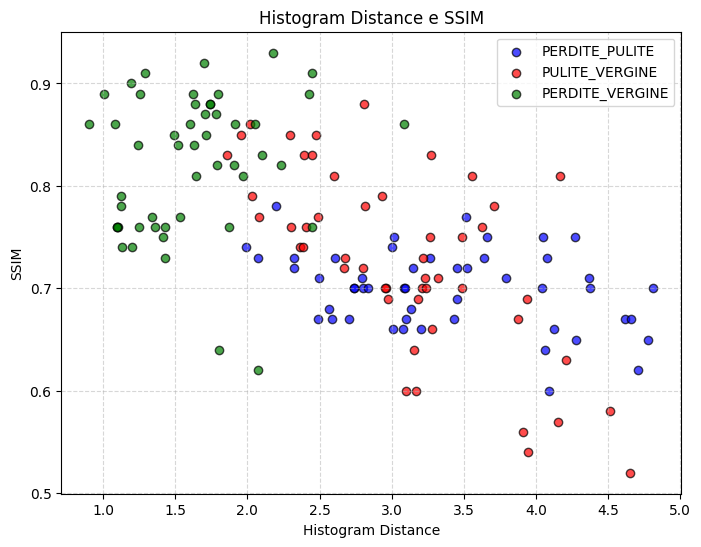

In [11]:
df_features = pd.read_csv(total_features_path, sep=",",skiprows=0 )
df_perdite_pulite = df_features[df_features["Label"] == "PERDITE_PULITE"]
df_pulite_vergine = df_features[df_features["Label"] == "PULITE_VERGINE"]
df_perdite_vergine = df_features[df_features["Label"] == "PERDITE_VERGINE"]

plt.figure(figsize=(8, 6))  
plt.scatter(df_perdite_pulite["Histogram_Distance"], df_perdite_pulite["SSIM"], color="blue", alpha=0.7, edgecolors="k", label="PERDITE_PULITE")
plt.scatter(df_pulite_vergine["Histogram_Distance"], df_pulite_vergine["SSIM"], color="red", alpha=0.7, edgecolors="k",label="PULITE_VERGINE")
plt.scatter(df_perdite_vergine["Histogram_Distance"], df_perdite_vergine["SSIM"], color="green", alpha=0.7, edgecolors="k",label="PERDITE_VERGINE")

plt.xlabel("Histogram Distance")
plt.ylabel("SSIM")
plt.title("Histogram Distance e SSIM")
plt.legend(loc="upper right")  # Posizione della legenda

plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig("plot_features.png", dpi=300, bbox_inches="tight") 
plt.show()

In [12]:
'''from ClusterFeatures import clusterFeatures
print (total_features_path)
features = pd.read_csv(total_features_path, sep=",")
print(features.columns)
clusterFeatures(total_features_path)'''

'from ClusterFeatures import clusterFeatures\nprint (total_features_path)\nfeatures = pd.read_csv(total_features_path, sep=",")\nprint(features.columns)\nclusterFeatures(total_features_path)'